# 2.1 Building our first convolutional neural network

In this example, we follow and build on one of the tutorials on the [homepage of PyTorch]( https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and we recommend this resource for delving deeper into the topic.

First, we load the libraries that we will need throughout this notebook.

1. <a href ="#Data">Data</a>
2. <a href ="#Architecture">Architecture</a>
3. <a href ="#Training">Training</a>
4. <a href ="#Testing">Testing</a>

In [1]:
# Needed for image handling
import torch
import torchvision
import torchvision.transforms as transforms
# Needed to build CNN
import torch.nn as nn
import torch.optim as optim
# Plotting tools
import matplotlib.pyplot as plt
import numpy as np
import time

## Data

In this notebook, we will work with the CIFAR10 dataset, containing thousands of images with 10 different labels (plane, car, bird, cat, deer, dog, frog, horse, ship and truck). Each picture has three channels (RGB) and is 32x32 pixels. Here, we seperately load the test and training data, constructing batches with 32 images each.

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Let's have a look at one of the pictures in the data set.

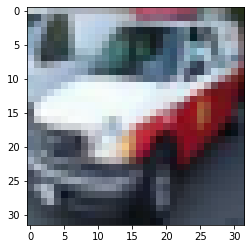

In [3]:
plt.imshow(trainset.data[60])
plt.show()

It's clearly a low resolution picture of a car. The labels in the data are simply the categories 0-9. Let's write labels that are easier for human's to relate to.

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Exercise 1**: In the code above, the pictures in the training and test sets are all normalised... why?

## Architecture

To create a convolutional neural network (CNN), we create a new class, here called CNN. We then initialise the class, inheriting from the parent class (here Module) and defining the necessary components of our architecture. Having initialised the class, we put the components together to define how a forward pass will be executed.

In [5]:
# How many 3 times three kernels do we want? 
# This will determine the dimensions of the output of convolution layers.

kernels = 6

class CNN(nn.Module):
    def __init__(self):
        super().__init__() # Inherit from parent class
        # Define layers
        # First we have a convolutional layer with 3 input channels and 32 output channels
        self.conv1 = nn.Conv2d(3, kernels, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) # Pooling layer
        self.conv2 = nn.Conv2d(kernels, kernels, kernel_size=(3,3), stride=1, padding=1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(kernels*8*8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Build CNN
        # input 3x32x32 and output 6x32x32
        x = self.act1(self.conv1(x))
        # input 6x32x32 and output 6x16x16
        x = self.pool1(x)
        # input 6x16x16 and output 6x16x16
        x = self.act1(self.conv2(x))
        # input 6x16x16 and output 6x8x8
        x = self.pool1(x)
        # We now flatten the feature maps to feed them into the neural network
        x = self.flat(x)
        x = self.act1(self.fc1(x))
        x = self.act1(self.fc2(x))
        x = self.fc3(x)
        return x

We can now construct an instance of this class that we can train and apply for predictions.

In [6]:
cnn = CNN()

But before we turn to training the network, let's have a look at what the different layers do to the images. Let's start with the first convolution layer.

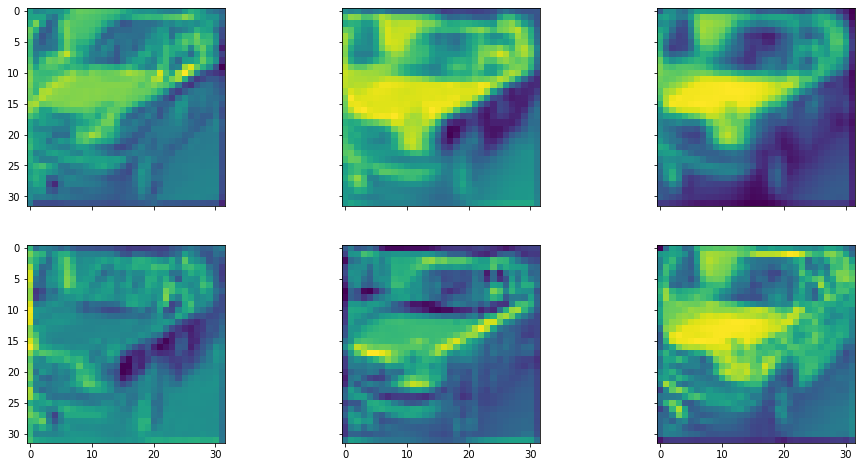

In [7]:
# First, we convert the image of the car into batch with one image
X = torch.tensor([trainset.data[60]], dtype=torch.float32).permute(0,3,1,2)
# Then we send it through conv1 to see what conv1 does.
with torch.no_grad(): # We don't actually need to compute gradients
    X = cnn.conv1(X)

# Plotting
cls = int(np.ceil(kernels/2))
fig, axs = plt.subplots(2, cls, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, kernels):
    row, col = i//cls, i%cls
    axs[row][col].imshow(X[0][i])
plt.show()

**Exercise 2**: Discuss in the group what the different layers in the CNN (e.g., [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Explain the dimensions of the input and output of each layer.

**Exercise 3**: In the network above, one type of activation function is included. Which one? What other types of [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
) are there?


**Exercise 4**: Change the code in the cell above to plot the output of the first pooling layer. Rather than passing the images to this layer, you will have to pass the output from conv1. Why?

## Training

Having defined the architecture of the CNN, we set out to train it. To do so, we first need to decide on what a good match to data implies (i.e. what is the loss function) and how to minimise the loss. Here, we settle for the cross entropy and stochastic gradient descent.

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

We are now ready to train the network. We do so through successive forward and backward propagation, optimising the weights. For simplicity, let's settle for training during 20 epochs, although fixing the number of epochs in this manner is rather crude and not to be recommended. Running this cell might take a few minutes.

[1,  1563] loss: 2.259
[2,  1563] loss: 1.972
[3,  1563] loss: 1.752
[4,  1563] loss: 1.595
[5,  1563] loss: 1.474
[6,  1563] loss: 1.376
[7,  1563] loss: 1.302
[8,  1563] loss: 1.243
[9,  1563] loss: 1.194
[10,  1563] loss: 1.156
[11,  1563] loss: 1.123
[12,  1563] loss: 1.094
[13,  1563] loss: 1.065
[14,  1563] loss: 1.040
[15,  1563] loss: 1.015
[16,  1563] loss: 0.986
[17,  1563] loss: 0.962
[18,  1563] loss: 0.939
[19,  1563] loss: 0.919
[20,  1563] loss: 0.894
Training time 126.46327710151672 seconds


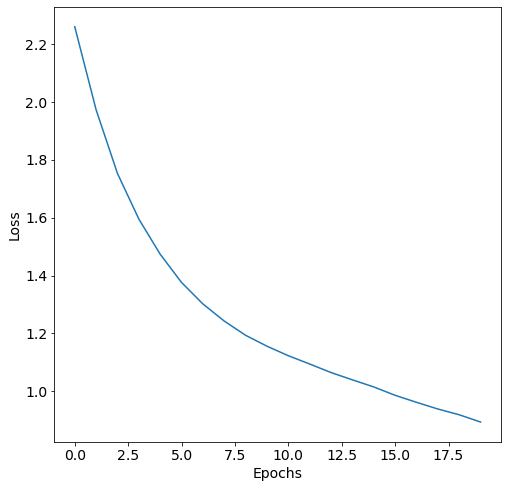

In [9]:
n_epochs = 20
tloss = []
start = time.time()
batches = np.ceil(len(trainloader.dataset)/batch_size)

for epoch in range(n_epochs):
    
    training_loss = 0.0
    for  i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        y_pred = cnn(inputs) # Go through batches of training data
        loss = loss_func(y_pred, labels) # Compare output to truth
        
        optimizer.zero_grad()
        
        # backward + optimize
        loss.backward()
        optimizer.step()
 
        training_loss += loss.item()
        if i % batches == batches-1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {training_loss / batches:.3f}')
            tloss.extend([training_loss / batches])
            training_loss = 0.0

print("Training time {} seconds".format(time.time()-start))

plt.figure(figsize=(8,8))
plt.plot(tloss)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Exercise 5**: Explain what happens in the code in the previous cell. What does the plot show? Does it look like expected?

Before we continue, let's store the trained network.

In [10]:
PATH = './cifar10_cnn.pth'
torch.save(cnn.state_dict(), PATH)

## Testing

We have successfully trained the network, but is it any good? Let's apply the network to the test data that we previously withheld to answer this question? For this purpose, let's start out by comparing some of the predicted labels with the ground truth.

In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = cnn(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(10)))
print('Truth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

Predicted:  cat   car   plane plane frog  frog  truck bird  cat   car  
Truth:  cat   ship  ship  plane frog  frog  car   frog  cat   car  


That doesn't look too bad. How does the model perform on the testset as a whole?

In [12]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    # calculate outputs by running images through the network
    outputs = cnn(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 62 %


If we were to guess randomly, the best we could do would be to get 10 per cent right with 10 categories. So, the model isn't doing that bad. But could we have done better? Should we have trained for longer than 20 epochs? What about overfitting? We will answer these questions next week.

**Exercise 6**: Change the architecture of the neural network. Try to introduce, e.g., dropout.

**Exercise 7**: Discuss the choice of the loss function. What alternatives are there?

**Exercise 8**: What happens if you change the number of kernels? Or the batchsize? Or the size of the training set?